<a href="https://colab.research.google.com/github/Malicious-traffic-in-IoT-networks/Deep-learning/blob/main/DDoS_Botnet_Attack_on_IOT_Devices_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LSTM**

Long Short Term Memory
장기 의존성 문제를 해결할 수 있는 RNNs 알고리즘의 한 종류



## **01 데이터 업로드**

In [414]:
# 구글 드라이브 연결
from google.colab import drive
import numpy as np
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [415]:
import pandas as pd

Train_Dataset = pd.read_csv('/gdrive/MyDrive/Taggle/IoT_Botnet_Final_Training.csv')
Test_Dataset = pd.read_csv('/gdrive/MyDrive/Taggle/IoT_Botnet_Dataset.csv')

In [416]:
# Train Data Size: [2934817 rows x 19 columns]
Train_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934817 entries, 0 to 2934816
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   pkSeqID            int64  
 1   proto              object 
 2   saddr              object 
 3   sport              object 
 4   daddr              object 
 5   dport              object 
 6   seq                int64  
 7   stddev             float64
 8   N_IN_Conn_P_SrcIP  int64  
 9   min                float64
 10  state_number       int64  
 11  mean               float64
 12  N_IN_Conn_P_DstIP  int64  
 13  drate              float64
 14  srate              float64
 15  max                float64
 16  attack             int64  
 17  category           object 
 18  subcategory        object 
dtypes: float64(6), int64(6), object(7)
memory usage: 425.4+ MB


In [417]:
# Test Data Size: [733704 rows x 19 columns]
Test_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733705 entries, 0 to 733704
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pkSeqID            733705 non-null  int64  
 1   proto              733705 non-null  object 
 2   saddr              733705 non-null  object 
 3   sport              733705 non-null  object 
 4   daddr              733705 non-null  object 
 5   dport              733705 non-null  object 
 6   seq                733705 non-null  int64  
 7   stddev             733705 non-null  float64
 8   N_IN_Conn_P_SrcIP  733705 non-null  int64  
 9   min                733705 non-null  float64
 10  state_number       733705 non-null  int64  
 11  mean               733705 non-null  float64
 12  N_IN_Conn_P_DstIP  733705 non-null  int64  
 13  drate              733705 non-null  float64
 14  srate              733705 non-null  float64
 15  max                733705 non-null  float64
 16  at

-pkSeqID: Row Identifier  
-seq: Argus sequence number  
-subcategory: Traffic subcategory  
-category (Target Column): Traffic category  



## **02 학습에 용이하도록 데이터셋 정리**

In [418]:
# 'category' 칼럼 이외의 것으로 패킷을 특정하지 않도록
# 'pkSeqID','seq','subcategory' 칼럼 제거

Train_Dataset.drop(["pkSeqID","seq","subcategory"], axis=1, inplace=True)
Test_Dataset.drop(["pkSeqID","seq","subcategory"], axis=1, inplace=True)
Train_Dataset.dtypes[Train_Dataset.dtypes=='object']

proto       object
saddr       object
sport       object
daddr       object
dport       object
category    object
dtype: object

In [419]:
drop_theft = Train_Dataset[Train_Dataset['category']=='Theft'].index
Train_Dataset.drop(drop_theft, inplace=True)

drop_theft = Test_Dataset[Test_Dataset['category']=='Theft'].index
Test_Dataset.drop(drop_theft, inplace=True)

In [420]:
# Train_Dataset 'sort' 칼럼에서 '0x' 문자열을 찾아 integer로 변환
search_string='0x'
result = set([i for i in Train_Dataset['sport'] if i.startswith(search_string)])
print(result)


{'0x0011', '0x0008', '0x0303', '0x000d'}


In [421]:
Train_Dataset['sport'] = Train_Dataset['sport'].replace(['0x0303'],'771') 
Train_Dataset['sport'] = Train_Dataset['sport'].replace(['0x0011'],'17')
Train_Dataset['sport'] = Train_Dataset['sport'].replace(['0x000d'],'13')
Train_Dataset['sport'] = Train_Dataset['sport'].replace(['0x0008'],'8')
Train_Dataset["sport"] = Train_Dataset["sport"].astype(str).astype(int)

In [422]:
# Train_Dataset 'dport' 칼럼에서 '0x' 문자열을 찾아 integer로 변환
search_string='0x'
result = set([i for i in Train_Dataset['dport'] if i.startswith(search_string)])
Train_Dataset['dport']=Train_Dataset.dport.apply(lambda x: int(x,16) if len(x)>1 and x[1]=="x" else int(x))


In [423]:
# 'dport' count 출력
Train_Dataset['dport'].value_counts()

 80       2858794
 1           5379
 3306        3757
 53           275
-1            163
           ...   
 40064          1
 40027          1
 40344          1
 3754           1
 61804          1
Name: dport, Length: 6778, dtype: int64

In [424]:
# Test_Dataset 'dport', 'sort' 칼럼에서 '0x' 문자열을 찾아 integer로 변환

Test_Dataset['sport'] = Test_Dataset['sport'].replace(['0x0303'],'771') 
Test_Dataset['sport'] = Test_Dataset['sport'].replace(['0x0011'],'17')
Test_Dataset['sport'] = Test_Dataset['sport'].replace(['0x000d'],'13')
Test_Dataset['sport'] = Test_Dataset['sport'].replace(['0x0008'],'8')
Test_Dataset["sport"] = Test_Dataset["sport"].astype(str).astype(int)

In [425]:
Test_Dataset['dport'] = Test_Dataset.dport.apply(lambda x: int(x,16) if len(x)>1 and x[1]=="x" else int(x))

## **03 데이터 정규화**

1) 레이블 인코딩 (Label Encoding): 카테고리 피처를 코드형 숫자 값으로 변환

In [426]:
# Train_Dataset

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Train_Dataset["saddr_enc"] = le.fit_transform(Train_Dataset.saddr)
Train_Dataset["daddr_enc"] = le.fit_transform(Train_Dataset.daddr)
Train_Dataset["proto_enc"] = le.fit_transform(Train_Dataset.proto)
Train_Dataset["category_enc"] = le.fit_transform(Train_Dataset.category)
Train_Dataset.drop(['saddr','daddr','proto','category'], axis=1, inplace=True)

In [427]:
# Test_Dataset 정규화
Test_Dataset["saddr_enc"] = le.fit_transform(Test_Dataset.saddr)
Test_Dataset["saddr_enc"] = le.fit_transform(Test_Dataset.saddr)
Test_Dataset["daddr_enc"] = le.fit_transform(Test_Dataset.daddr)
Test_Dataset["proto_enc"] = le.fit_transform(Test_Dataset.proto)
Test_Dataset["category_enc"] = le.fit_transform(Test_Dataset.category)
Test_Dataset.drop(['saddr','daddr','proto','category'], axis=1, inplace=True)

In [428]:
y_train = Train_Dataset["category_enc"]
y_test = Test_Dataset["category_enc"]

3) StandardScaler

In [429]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
features = Train_Dataset.iloc[:,:-1]
cols=features.columns
scaled_features= scaler.fit_transform(features)
Train_Dataset= pd.DataFrame(scaled_features,columns=cols)

features = Test_Dataset.iloc[:,:-1]
cols=features.columns
scaled_features= scaler.fit_transform(features)
Test_Dataset= pd.DataFrame(scaled_features,columns=cols)


In [430]:
pd.Series(y_test).value_counts()

0    385309
1    330112
3     18163
2       107
Name: category_enc, dtype: int64

In [431]:
pd.Series(y_train).value_counts()

0    1541315
1    1320148
3      72919
2        370
Name: category_enc, dtype: int64

## **04 데이터 세트 조정**

1) RandomOverSampler, RandomUnderSampler

In [432]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn import model_selection
from sklearn.svm import SVC
import imblearn

# RandomOverSampler : 중복된 데이터를 기존의 데이터에 추가하여 데이터의 절대적인 양을 늘리는 것
samp_strat= { 0 : 1541315, 1 : 1320148, 2 : 72919, 3 : 72919}
random_over= RandomOverSampler(sampling_strategy=samp_strat,random_state=1)
Xres,yres = random_over.fit_resample(Train_Dataset, y_train)

# RandomUnderSampler: 많은 비율을 차지하는 다수 집단에서 일부만 샘플링
from imblearn.under_sampling import RandomUnderSampler
samp_strat= { 0 : 72919, 1 : 72919, 2 : 72919, 3 : 72919}
random_under= RandomUnderSampler(sampling_strategy=samp_strat,random_state=1)
Xres1,yres1 = random_under.fit_resample(Xres,yres)


In [433]:
pd.Series(yres1).value_counts()

0    72919
1    72919
2    72919
3    72919
Name: category_enc, dtype: int64

In [434]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
samp_strat= { 0 : 385309, 1 : 330112, 2 : 330112, 3 : 330112}
random_over_1= RandomOverSampler(sampling_strategy=samp_strat,random_state=1)
test,y_test = random_over_1.fit_resample(Test_Dataset, y_test)

In [435]:
pd.Series(y_test).value_counts()

0    385309
1    330112
3    330112
2    330112
Name: category_enc, dtype: int64

In [436]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
samp_strat= { 0 : 14584, 1 : 14584, 2 : 14584, 3 : 14584}
random_over_2= RandomUnderSampler(sampling_strategy=samp_strat,random_state=1)
test,y_test = random_over_2.fit_resample(test,y_test)

In [437]:
# RandomUnderSampler을 통해 데이터의 절대적인 양이 줄어든 것 확인

pd.Series(y_test).value_counts()

0    14584
1    14584
2    14584
3    14584
Name: category_enc, dtype: int64

2) 정확도가 0.98이 넘었을 때 호출 할 myCallback 선언

In [438]:
# Tensorflow의 callbacks를 확인하여 정확도가 0.98이 넘었을 때 학습 멈출 myCallback 선언
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callback=myCallback()

2) learning rage 정의를 위해 옵티마이저 초기화

In [439]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

In [440]:
Xres1.shape

(291676, 15)

## **05 LSTM**

1) 4개의 밀집 계층의 Simple RNN 모델 
- LSTM
- Dense (Layer 20, 60, 80, 90)
- Dense (Softmax)

In [441]:
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN
from keras.models import Sequential

n_samples, n_feats = Xres1.shape[0], Xres1.shape[1]
Xres1=np.array(Xres1)
Xres1 = Xres1.reshape((n_samples, n_feats, 1))
yres1=np.array(yres1)
yres1 = to_categorical(yres1, 4)
model = Sequential()
model.add(LSTM(n_feats, input_shape=(n_feats, 1)))
model.add(Dense(20))
model.add(Dense(60))
model.add(Dense(80))
model.add(Dense(90))
model.add(Dense(4, activation='softmax'))

In [442]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [443]:
# test 데이터 세트 준비
n_samples, n_feats = test.shape[0], test.shape[1]
test=np.array(test)
test = test.reshape((n_samples, n_feats, 1))
y_test=np.array(y_test)
y_test = to_categorical(y_test, 4)

In [444]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 15)                1020      
                                                                 
 dense_35 (Dense)            (None, 20)                320       
                                                                 
 dense_36 (Dense)            (None, 60)                1260      
                                                                 
 dense_37 (Dense)            (None, 80)                4880      
                                                                 
 dense_38 (Dense)            (None, 90)                7290      
                                                                 
 dense_39 (Dense)            (None, 4)                 364       
                                                                 
Total params: 15,134
Trainable params: 15,134
Non-trai

2) 학습

In [445]:
history = model.fit(Xres1, yres1,batch_size=256,
                                    epochs=1000,
                                    validation_data=(test, y_test),callbacks =[callback],
                                    workers=4)

Epoch 1/1000
1140/1140 [==============================] - 20s 15ms/step - loss: 0.5295 - accuracy: 0.7713 - val_loss: 0.2989 - val_accuracy: 0.8596
Epoch 2/1000
1140/1140 [==============================] - 15s 14ms/step - loss: 0.2852 - accuracy: 0.8722 - val_loss: 0.2588 - val_accuracy: 0.8852
Epoch 3/1000
1140/1140 [==============================] - 15s 13ms/step - loss: 0.2450 - accuracy: 0.8938 - val_loss: 0.2186 - val_accuracy: 0.9034
Epoch 4/1000
1140/1140 [==============================] - 15s 13ms/step - loss: 0.2051 - accuracy: 0.9144 - val_loss: 0.1962 - val_accuracy: 0.9119
Epoch 5/1000
1140/1140 [==============================] - 17s 15ms/step - loss: 0.1801 - accuracy: 0.9257 - val_loss: 0.1721 - val_accuracy: 0.9299
Epoch 6/1000
1140/1140 [==============================] - 20s 18ms/step - loss: 0.1639 - accuracy: 0.9339 - val_loss: 0.1540 - val_accuracy: 0.9399
Epoch 7/1000
1140/1140 [==============================] - 14s 13ms/step - loss: 0.1516 - accuracy: 0.9406 - val_

3) Plotting model accuracy, validation accuracy와 loss 그래프 출력

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


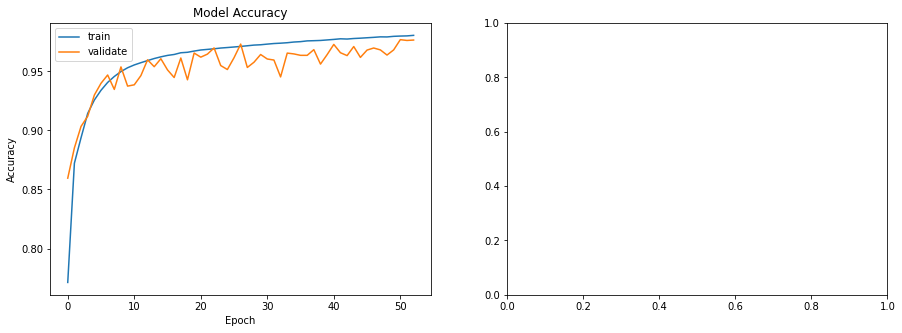

In [482]:
import matplotlib.pyplot as plt

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
 
print(history.history.keys())
plotmodelhistory(history)
plt.savefig('Mode Accuracy and Loss',dpi=300)

4) 손실과 정확도 측정

In [447]:
scores = model.evaluate(test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1823/1823 [==============================] - 6s 3ms/step - loss: 0.0701 - accuracy: 0.9765
Test loss: 0.07014875113964081
Test accuracy: 0.9764810800552368


5) 특성별 정확도 측정
- ROC(Receiver Operating Characteristic)  
- 다양한 feautue에 대한 분류기의 성능을 한번에 표시  
- X축/FPR (False positive rate): 케이스에 대해 틀리게 예측하는 비율  
- Y축/TPR (True Positive Rate): 케이스에 대해 바르게 예측하는 비율

In [448]:
ypred = model.predict(Xres1)
ypred = ypred.argmax(axis=-1)
yres1 = yres1.argmax(axis=-1)

9115/9115 [==============================] - 26s 3ms/step


ROC AUC score: 0.9889992091681638


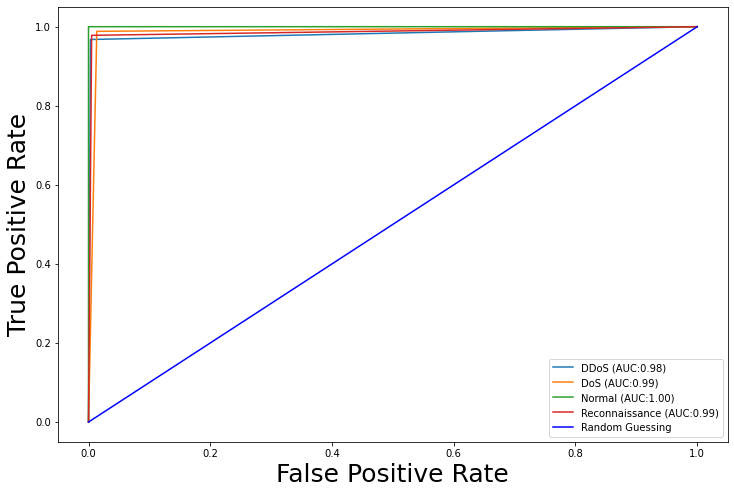

In [449]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 'DDoS', 'DoS', 'Normal', 'Reconnaissance' 타겟에 대한 예측 진행
target = ['DDoS', 'DoS', 'Normal', 'Reconnaissance']

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(yres1, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate', fontsize=25)
c_ax.set_ylabel('True Positive Rate',fontsize=25)
plt.savefig('ROC_LSTM',dpi=300)
plt.show()